# **In-Class Assignment: Topic Modeling**

## *DATA 5420/6420*
## Name: Dallin Moore

Topic modeling is a more sophisticated approach to extracting topics/themes from a corpus than some of the more simple methods we discussed during class, like key phrase extraction. There are a number of algorithms that can be used to peform topic modeling, we will focus on the most common, called LDA.

*   Latent Dirichlet Allocation

In this in-class assignment we will implement the above method on a corpus of research papers from the NeurIPS conference to try and extract meaningful topic labels for these papers. While we will focus on LDA, there are other methods for performing topic modeling like LSI, and NMF.


In [1]:
# load all dependencies
import nltk
import gensim

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim
import matplotlib.pyplot as plt

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **1) Data Retrieval**

We will be downloading the dataset directly using the following commands:

In [2]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

--2024-03-08 03:49:06--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  20.5MB/s    in 0.6s    

2024-03-08 03:49:07 (20.5 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



#### **A) Data Extraction**

We need to uncompress this tgz file and extract the different text files within each of the subfolders, like so:

In [3]:
!tar -xzf nips12raw_str602.tgz

In [4]:
DATA_PATH = '/content/nipstxt'                                    # add in content path
print(os.listdir(DATA_PATH))

['README_yann', 'MATLAB_NOTES', 'nips11', 'nips06', 'nips10', 'nips05', 'idx', 'orig', 'nips00', 'nips07', 'nips09', 'nips03', 'nips01', 'nips04', 'nips12', 'nips02', 'RAW_DATA_NOTES', 'nips08']


## **2) Basic Text Preprocessing**

Let's think about which text cleaning step we want to implement here for a process like topic modeling, where the goal is to group together terms that tend to co-occur with one another across documents to essentially form clusters of terms -- which form topics

In [5]:
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmas)

In [6]:
# specify the folders we want to extract from
folders = ["nips{0:02}".format(i) for i in range(0, 5)]
papers = []

for folder in folders: # create a list of filenames within each folder
    folder_path = os.path.join(DATA_PATH, folder)
    file_names = os.listdir(folder_path)

# for each file, create the full file path, read in the file, preprocess the text, append to list of all papers
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, encoding='utf-8', errors='ignore') as f:
        data = f.read()
        preprocessed_data = preprocess_text(data)
        papers.append(preprocessed_data)

In [7]:
papers[0][:1000]

'node splitting constructive algorithm feed forward neural network mike wynne jones research initiative pattern recognition st andrew road great malvern wr p uk mikewj hermes mod uk abstract constructive algorithm proposed feed forward neural network us node splitting hidden layer build large network smaller one small network form approximate model set training data split creates larger powerful network initialised approximate solution already found insufficiency smaller network modelling system generated data lead oscillation hidden node whose weight vector cover gions input space detail required model node identified split two using principal component analysis allowing new node cover two main mode oscillating vector node selected splitting using principal component analysis oscillating weight vector examining hessian matrix second derivative network error respect weight second derivative method also applied input layer provides useful indication relative importance parameter classif

## 3) **Feature Engineering**

Before we perform any sort of vectorization, we're going to narrow down our pool of words to more common n-grams; specifically bigrams where the min_df = 2, and the max_df = 0.70, meaning...

In [8]:
tv = TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(2,2))
dtm = tv.fit_transform(papers)
vocabulary = np.array(tv.get_feature_names_out())
dtm.shape

(144, 16858)

In [10]:
pd.DataFrame(dtm.toarray(), columns=vocabulary, index=['Doc_'+str(i) for i in range(len(papers))])

,aaai press,ability distribution,ability generalize,ability generate,ability model,ability network,ability neural,ability proc,ability recognize,able approximate,...,zip code,zipcode recognition,zipser learning,zipset andersen,zipset learning,zisserman visual,zky ed,zky editor,zt zt,zurich switzerland
Doc_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
Doc_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.032153,0.0,0.0,0.000000
Doc_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.057234,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
Doc_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
Doc_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.027523,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc_139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
Doc_140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
Doc_141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.037743,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.037743
Doc_142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.038804,0.000000,0.0,0.0,0.000000


**Why might we use bigrams here in place of unigrams?**

There a lot of concepts within the texts like 'maching learning' that lose meaning when they are considered as unigrams, which makes bigrams more useful for this scenario.

## **4) Topic Modeling with Latent Dirichlet Allocation (LDA)**

Let's start by first just running a topic model and examining the top features

In [11]:
# Fit LDA Model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(random_state=42)

> #### **A) Print topics with top 10 words per topic**

In [12]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))


no_top_words = 10
display_topics(lda, vocabulary, no_top_words)

Topic 0:
test set, silicon retina, weight decay, memory based, et al, hidden unit, feature extractor, feature map, dendritic tree, sp sp
Topic 1:
winner take, model merging, horizontal cell, take network, motion energy, target location, training data, domain theory, limit cycle, error rate
Topic 2:
spinal cord, network model, model image, expert network, et al, change model, horn usher, muscle tension, gating network, cross validation
Topic 3:
hidden unit, uniform convergence, center location, recurrent network, context unit, pid controller, relative frequency, knowledge base, second order, supervised learning
Topic 4:
weight decay, mistake rate, empirical risk, auditory nerve, tone burst, feature unit, segmentation recognition, spatial frequency, firing rate, deterministic annealing
Topic 5:
hidden unit, training set, control point, rational function, rem sleep, degree approximation, training data, learning curve, evoked potential, piecewise linear
Topic 6:
hidden unit, wind speed, ne

**But how do we know if this is a reasonable number of topics? What are some ways we could define that?**

By looking at topic cogerence we can see what the similarity is betweeen all of the topics to know if any of the topics are somewhat uncommon. We could also look at other metrics like perplexity to get a similar understanding.

> #### **B) Examining Topic Coherence**

**Let's now get an idea of how our topic model is performing by computing the perplexity and the coherence scores (UMass).**

In [14]:
# sci-kit learn does not support coherenc score so a different lda model must be brought in for the score
def custom_tokenizer(text):
    # create unigrams
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # create bigrams
    bigrams = ["_".join(tokens[i:i+2]) for i in range(len(tokens)-1)]
    return bigrams

tokenized_texts = [custom_tokenizer(text) for text in papers]                          # create a list of bigram strings for each paper

**Annoyingly sklearn doesn't do coherence scores so we have to convert our LDA model to a gensim (another NLP library in python) model**

In [15]:
gensim_dict = Dictionary(tokenized_texts)
gensim_dict.filter_extremes(no_below=2, no_above=0.7) # we need to set this to the same filtering we did during our vectorization step
print(gensim_dict)

Dictionary<18643 unique tokens: ['ac_cording', 'acknowledgement_author', 'adaptive_network', 'add_new', 'added_weight']...>


**Instead of just examining different numbers of topics individually, let's set a range of topics to examine coherence (UMass) scores for and then plot the change in coherence for each topic, we can do this efficiently with a for loop:**

In [18]:
# Container to hold coherence values
coherence_values = []

topic_nums = range(10, 16) # try 10 to 15 topics

# fit LDA model for each value of topic_nums
for num_topics in topic_nums:
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(dtm)
    # extract top features for each topic, replace with vocab word
    word_ids = lda_model.components_.argsort(axis=1)[:, ::-1][:, :10]
    topics = [[tv.get_feature_names_out()[i].replace(" ", "_") for i in topic_word_ids] for topic_word_ids in word_ids]
    # print extracted topics
    print(f"Extracted topics for num_topics={num_topics}:")
    for idx, topic in enumerate(topics):
        print(f"Topic {idx}: {topic}")
    # calculate and append the topic score
    coherence_model_lda = CoherenceModel(topics=topics, texts=tokenized_texts, dictionary=gensim_dict, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"UMass for num_topics={num_topics}: {coherence_lda}\n")

    coherence_values.append(coherence_lda)

Extracted topics for num_topics=10:
Topic 0: ['test_set', 'silicon_retina', 'weight_decay', 'memory_based', 'et_al', 'hidden_unit', 'feature_extractor', 'feature_map', 'dendritic_tree', 'sp_sp']
Topic 1: ['winner_take', 'model_merging', 'horizontal_cell', 'take_network', 'motion_energy', 'target_location', 'training_data', 'domain_theory', 'limit_cycle', 'error_rate']
Topic 2: ['spinal_cord', 'network_model', 'model_image', 'expert_network', 'et_al', 'change_model', 'horn_usher', 'muscle_tension', 'gating_network', 'cross_validation']
Topic 3: ['hidden_unit', 'uniform_convergence', 'center_location', 'recurrent_network', 'context_unit', 'pid_controller', 'relative_frequency', 'knowledge_base', 'second_order', 'supervised_learning']
Topic 4: ['weight_decay', 'mistake_rate', 'empirical_risk', 'auditory_nerve', 'tone_burst', 'feature_unit', 'segmentation_recognition', 'spatial_frequency', 'firing_rate', 'deterministic_annealing']
Topic 5: ['hidden_unit', 'training_set', 'control_point', '

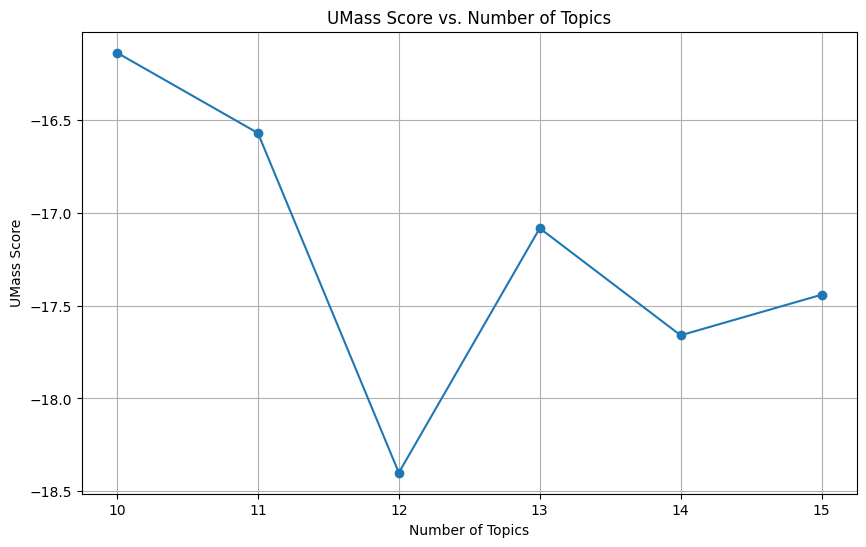

In [19]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(topic_nums, coherence_values, marker='o')
plt.title('UMass Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('UMass Score')
plt.grid(True)
plt.show()

**How do we interpret U_Mass? What is the optimal number of topics between 10-15 for this dataset?**

We want to maximize the coherence, so, for this dataset, the highest is 10 topics so that is the optimal number.

## **Rerun with optimal topic number**

In [20]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
doc_topic = lda.fit(dtm)

## **Examine top features per topic**

In [21]:
no_top_words = 10
display_topics(doc_topic, vocabulary, no_top_words)

Topic 0:
test set, silicon retina, weight decay, memory based, et al, hidden unit, feature extractor, feature map, dendritic tree, sp sp
Topic 1:
winner take, model merging, horizontal cell, take network, motion energy, target location, training data, domain theory, limit cycle, error rate
Topic 2:
spinal cord, network model, model image, expert network, et al, change model, horn usher, muscle tension, gating network, cross validation
Topic 3:
hidden unit, uniform convergence, center location, recurrent network, context unit, pid controller, relative frequency, knowledge base, second order, supervised learning
Topic 4:
weight decay, mistake rate, empirical risk, auditory nerve, tone burst, feature unit, segmentation recognition, spatial frequency, firing rate, deterministic annealing
Topic 5:
hidden unit, training set, control point, rational function, rem sleep, degree approximation, training data, learning curve, evoked potential, piecewise linear
Topic 6:
hidden unit, wind speed, ne

**As mentioned before, we can augment our analysis here with ChataGPT, to help us understand these top features and apply a meaningful label.**

**Try copying and pasting the list above into chatgpt and asking it to provide topic labels for these neurips papers.**

ChatGPT output:


*   Topic 0: Neural Network Architecture
*   Topic 1: Neural Network Training and Optimization
*   Topic 2: Neural Network Models in Biomedical Research
*   Topic 3: Neural Network Learning Algorithms
*   Topic 4: Neural Network Performance Evaluation
*   Topic 5: Neural Network Training Techniques
*   Topic 6: Neural Network Applications in Wind Speed Prediction
*   Topic 7: Neural Network Structures and Dynamics
*   Topic 8: Neural Network Regression and Function Approximation
*   Topic 9: Neural Network Model Evaluation and Testing



## **Finally, let's examine the topic breakdown by document**

In [23]:
doc_topic_matrix = lda.transform(dtm)

df_doc_topic = pd.DataFrame(doc_topic_matrix, columns=[f'Topic {i}' for i in range(lda.n_components)])
df_doc_topic

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.950595,0.005490,0.005490,0.005489,0.005489,0.005490,0.005489,0.005490,0.005489,0.005489
1,0.005578,0.949792,0.005580,0.005581,0.005579,0.005578,0.005578,0.005579,0.005577,0.005578
2,0.008111,0.008109,0.008110,0.008110,0.927008,0.008111,0.008109,0.008110,0.008111,0.008111
3,0.007261,0.007264,0.007260,0.007265,0.007262,0.007261,0.007261,0.934641,0.007261,0.007264
4,0.005670,0.005676,0.005673,0.005671,0.005671,0.005671,0.005671,0.948955,0.005671,0.005672
...,...,...,...,...,...,...,...,...,...,...
139,0.942301,0.006410,0.006411,0.006411,0.006410,0.006410,0.006411,0.006413,0.006409,0.006413
140,0.010514,0.010515,0.010517,0.010514,0.010517,0.905363,0.010515,0.010515,0.010516,0.010515
141,0.005246,0.005248,0.005247,0.005247,0.005246,0.952776,0.005247,0.005247,0.005249,0.005246
142,0.005435,0.005436,0.951073,0.005436,0.005437,0.005438,0.005436,0.005436,0.005437,0.005435


In [28]:
papers[131][300:2000]

'problem number important practical issue identified discussed general theoretical per spective practical issue examined context case study td applied learning game backgammon outcome self play apparently first application algorithm complex nontrivial task found zero knowledge built network able learn scratch play entire game fairly strong intermediate level performance clearly better conventional commercial program fact surpasses comparable network trained massive human expert data set hidden unit network apparently discovered useful feature longstanding goal computer game research furthermore set hand crafted feature added input representation resulting network reach near expert level performance achieved good result world class human play introduction consider prospect application td algorithm delayed inforcement learning proposed sutton complex real world problem td algorithm adjusting weight connectionist network w hich tesauro following form aw p p v p pt network output upon obse

**What other sorts of corpora or text data could be examined using topic modeling? Where would it be less useful and what could be an alternative?**

Social media data could be interesting to look at. From a platform like X, looking at what topics are being discussed could be catered to specific users that are more likely to enjoy that topic.

However, short texts may not perform as well, but other methods like keyword extraction or clustering techniques might be more suitable.